In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from numpy.linalg import norm
from math import sqrt

### Please, run on python 3.8 and don't use seaborn themes for good-looking histograms

In [48]:
def calculate_k(x, y, through_zero=False):
    '''
    Вычисление коэффициентов для аппроксимации зависимостью y = kx + b
    Возвращает: [k, s_k, b, s_b]
    '''
    n = len(x)
    m_x = x.mean()
    m_y = y.mean()
    m_xx = (x * x). mean()
    m_yy = (y * y).mean()
    m_xy = (x * y).mean()
    m_x_m_x = x.mean() * x.mean()
    m_y_m_y = y.mean() * y.mean()

    k = 0
    s_k = 0
    b = 0
    s_b = 0

    if through_zero:
        k = m_xy / m_xx
        s_k = (1 / sqrt(n)) * sqrt((m_yy / m_xx) - k ** 2)
        return [k, s_k]

    else:
        k = (m_xy - m_x * m_y) / (m_xx - m_x_m_x)
        b = m_y - k * m_x

        s_k = (1 / sqrt(n)) * sqrt((m_yy - m_y_m_y) / (m_xx - m_x_m_x) - k ** 2)
        s_b = s_k * sqrt(m_xx - m_x_m_x)
        return [k, s_k, b, s_b]

In [49]:
N = 100
def make_df_get_Dt(path, N):
    df = pd.read_csv(path, skiprows=[0,1, 2])

    with open(path) as f:
        f.readline()
        line = f.readline()

    Dt = float(line.split(':')[-1][:-1])    # шаг по времени для соседних строчек в диффузии

    return df, Dt

def calculate_all_means(max_step, df, Dt, interval_for_step=10):
    '''
    Возвращает массив из усредненного по всем перемещениям для каждой частицы и затем по всем частиц из перемещений для разных времен перемещения
    и массив отрезков времени для которых как раз получено значение перемещения.
    df: pd.Dataframe
    Dt: расстояние по времени между двумя соседними строчками в датафрейме
    '''

    steps = [step for step in range(1, max_step + 1, interval_for_step)]    # через такое количество строчек я смотрю перемещение-проходясь по циклу я для разных времен перемещения получаю значения
    # print(steps)
    
    all_means = []
    for step in steps:
        part_dict = {}
        for i in range(N):
            part_dict[i] = np.array([])
        
        for row_numb in steps:
            for p_numb in range(N):
                row = df.iloc[row_numb]
                x = row[str(p_numb) + 'x']
                y = row[str(p_numb) + 'y']
                z = row[str(p_numb) + 'z']
                pos = np.array([x, y, z])

                row_next = df.iloc[row_numb + step]     # берем для той же частицы с шагом step ряд
                x_next = row_next[str(p_numb) + 'x']
                y_next = row_next[str(p_numb) + 'y']
                z_next = row_next[str(p_numb) + 'z']
                pos_next = np.array([x_next, y_next, z_next])
                
                s_square = norm(pos_next - pos) ** 2
                part_dict[p_numb] = np.append(part_dict[p_numb], s_square)

        mean_dict = {}
        for i in range(N):
            mean_dict[i] = part_dict[i].mean()

        total_mean_for_step = np.array(list(mean_dict.values())).mean()

        all_means.append(total_mean_for_step)

    return all_means, Dt * np.array(steps)

def get_point_of_transition(xs, ys, tol=0.01):
    '''
    returns two points: 1) where derivitive becomes almost constant, going from beggining, 2) where it changes, when going from the end
    '''
    deriv = (max(ys) - min(ys)) / (max(xs) - min(xs))
    start_flag = True
    x0, y0 = xs[0], ys[0]

    for x1, y1 in zip(xs[1:], ys[1:]):
        if start_flag:
            deriv = (y1 - y0) / (x1 - x0)
            start_flag = False

        deriv = (y1 - y0) / (x1 - x0)
        print(f'deriv: {deriv}, (x1 y1): {x1, y1}')
        x0, y0 = x1, y1


def convert_into_ready_diffusion(all_means, dt_of_steps, out_path='graphs/diffusion_ready/100p_300k_ready.csv'):
    pd.DataFrame(
        {'all_means': all_means, 'dt_of_steps': dt_of_steps}
    ).to_csv(out_path, index=False)

def plot_ready_diffusion(path='./graphs/diffusion_ready/100p_300k_ready.csv', n_approx=30):
    '''Возвращает значение коэффициента диффузии'''
    df = pd.read_csv(path)
    dt_of_steps = df['dt_of_steps']
    all_means = df['all_means']

    plt.figure(figsize=(12, 7))
    sp = None

    # Обычный subplot:
    # построим прямую по последним n_approx точкам:
    k_basic, _, b_basic, _ = calculate_k(dt_of_steps[-130:], all_means[-130:])
    x = dt_of_steps

    plt.subplot(1, 2, 1)
    plt.scatter(dt_of_steps, all_means)
    plt.plot(x, k_basic * x + b_basic, color='red', label=f'k = {round(k_basic, 2)}, D = {round(k_basic / 6, 2)}')
    # print(k_basic)
    plt.legend(loc='best')

    plt.xlabel('$\Delta t$ of movement, $\sigma\cdot\sqrt{\dfrac{M}{\epsilon}}$', fontsize=14)
    plt.ylabel('$|\Delta r|^2$, $\sigma^2$', fontsize=14)

    # Логарифмический subplpt:
    x = np.log(dt_of_steps)
    y = np.log(all_means)
    plt.subplot(1, 2, 2)

    # Построим прямую по МНК на первых n_approx и прямую на последних 2 * n_approx точках
    x_parab, y_parab = x[:n_approx // 2], y[:n_approx // 2]
    k_parab, _, b_parab, _ = calculate_k(x_parab, y_parab, through_zero=False)
    x_lin, y_lin = x[-4 * n_approx:], y[-4 * n_approx:]
    k_lin, _, b_lin, _ = calculate_k(x_lin, y_lin, through_zero=False)
    
    x_parab = x[:len(x) // 2]
    x_lin = x[int(-len(x) * 0.92):]

    plt.plot(x_parab, k_parab * x_parab + b_parab, color='red')
    plt.plot(x_lin, k_lin * x_lin + b_lin, color='orange')
    plt.scatter(x, y)

    plt.xlabel('$log(\Delta t$ of movement), $\sigma\cdot\sqrt{\dfrac{M}{\epsilon}}$', fontsize=14)
    plt.ylabel('$log(|\Delta r|^2)$, $\sigma^2$', fontsize=14)

    plt.show()

    return round(k_basic / 6, 3)

In [50]:

def calculate_all_means(max_step, df, Dt, interval_for_step=10):
    '''
    Возвращает массив из усредненного по всем перемещениям для каждой частицы и затем по всем частиц из перемещений для разных времен перемещения
    и массив отрезков времени для которых как раз получено значение перемещения.
    df: pd.Dataframe
    Dt: расстояние по времени между двумя соседними строчками в датафрейме
    '''

    steps = [step for step in range(1, max_step + 1, interval_for_step)]    # через такое количество строчек я смотрю перемещение-проходясь по циклу я для разных времен перемещения получаю значения
    # print(steps)
    
    all_means = []
    for step in steps:
        part_dict = {}
        for i in range(N):
            part_dict[i] = np.array([])
        
        for row_numb in steps:
            for p_numb in range(N):
                row = df.iloc[row_numb]
                x = row[str(p_numb) + 'x']
                y = row[str(p_numb) + 'y']
                z = row[str(p_numb) + 'z']
                pos = np.array([x, y, z])

                row_next = df.iloc[row_numb + step]     # берем для той же частицы с шагом step ряд
                x_next = row_next[str(p_numb) + 'x']
                y_next = row_next[str(p_numb) + 'y']
                z_next = row_next[str(p_numb) + 'z']
                pos_next = np.array([x_next, y_next, z_next])
                
                s_square = norm(pos_next - pos) ** 2
                part_dict[p_numb] = np.append(part_dict[p_numb], s_square)

        mean_dict = {}
        for i in range(N):
            mean_dict[i] = part_dict[i].mean()

        total_mean_for_step = np.array(list(mean_dict.values())).mean()

        all_means.append(total_mean_for_step)

    return all_means, Dt * np.array(steps)

def get_point_of_transition(xs, ys, tol=0.01):
    '''
    returns two points: 1) where derivitive becomes almost constant, going from beggining, 2) where it changes, when going from the end
    '''
    deriv = (max(ys) - min(ys)) / (max(xs) - min(xs))
    start_flag = True
    x0, y0 = xs[0], ys[0]

    for x1, y1 in zip(xs[1:], ys[1:]):
        if start_flag:
            deriv = (y1 - y0) / (x1 - x0)
            start_flag = False

        deriv = (y1 - y0) / (x1 - x0)
        print(f'deriv: {deriv}, (x1 y1): {x1, y1}')
        x0, y0 = x1, y1


def convert_into_ready_diffusion(all_means, dt_of_steps, out_path='graphs/diffusion_ready/100p_300k_ready.csv'):
    pd.DataFrame(
        {'all_means': all_means, 'dt_of_steps': dt_of_steps}
    ).to_csv(out_path, index=False)

def plot_ready_diffusion(path='./graphs/diffusion_ready/100p_300k_ready.csv', n_approx=30):
    '''Возвращает значение коэффициента диффузии'''
    df = pd.read_csv(path)
    dt_of_steps = df['dt_of_steps']
    all_means = df['all_means']

    plt.figure(figsize=(12, 7))
    sp = None

    # Обычный subplot:
    # построим прямую по последним n_approx точкам:
    k_basic, _, b_basic, _ = calculate_k(dt_of_steps[-130:], all_means[-130:])
    x = dt_of_steps

    plt.subplot(1, 2, 1)
    plt.scatter(dt_of_steps, all_means)
    plt.plot(x, k_basic * x + b_basic, color='red', label=f'k = {round(k_basic, 2)}, D = {round(k_basic / 6, 2)}')
    # print(k_basic)
    plt.legend(loc='best')

    plt.xlabel('$\Delta t$ of movement, $\sigma\cdot\sqrt{\dfrac{M}{\epsilon}}$', fontsize=14)
    plt.ylabel('$|\Delta r|^2$, $\sigma^2$', fontsize=14)

    # Логарифмический subplpt:
    x = np.log(dt_of_steps)
    y = np.log(all_means)
    plt.subplot(1, 2, 2)

    # Построим прямую по МНК на первых n_approx и прямую на последних 2 * n_approx точках
    x_parab, y_parab = x[:n_approx // 2], y[:n_approx // 2]
    k_parab, _, b_parab, _ = calculate_k(x_parab, y_parab, through_zero=False)
    x_lin, y_lin = x[-4 * n_approx:], y[-4 * n_approx:]
    k_lin, _, b_lin, _ = calculate_k(x_lin, y_lin, through_zero=False)
    
    x_parab = x[:len(x) // 2]
    x_lin = x[int(-len(x) * 0.92):]

    plt.plot(x_parab, k_parab * x_parab + b_parab, color='red')
    plt.plot(x_lin, k_lin * x_lin + b_lin, color='orange')
    plt.scatter(x, y)

    plt.xlabel('$log(\Delta t$ of movement), $\sigma\cdot\sqrt{\dfrac{M}{\epsilon}}$', fontsize=14)
    plt.ylabel('$log(|\Delta r|^2)$, $\sigma^2$', fontsize=14)

    plt.show()

    return round(k_basic / 6, 3)

In [51]:
def make_ready_csv_diff(
    input_path='./graphs_rho_1_27/diffusion.csv',
    N=100, max_step=2380, interval_for_step=16,
    out_path='./graphs_rho_1_27/diffusion_ready/t_0_68_ready.csv'):
    '''
    Параметры по умолчанию стоят для файлов финального формата
    '''
    df, Dt = make_df_get_Dt(path=input_path, N=N)
    all_means, dt_of_steps = calculate_all_means(max_step=max_step, df=df, Dt=Dt, interval_for_step=interval_for_step)
    convert_into_ready_diffusion(dt_of_steps=dt_of_steps, all_means=all_means, out_path=out_path)

def plot_energies_from_file(path='./energies.csv', who_to_plot=['Total'], show=True):
    plt.figure(figsize=(12, 7))
    df = pd.read_csv(path)
    time = df.time
    for column in df.loc[:, who_to_plot]:
        plt.plot(time, df[column], label=column)
    plt.legend(loc='best', fontsize=14)
    plt.xlabel('Время, $\sigma\cdot\sqrt{\dfrac{M}{\epsilon}}$', fontsize=12)
    plt.ylabel('Энергия, $E/\epsilon$', fontsize=12)
    if show:
        plt.show()

def plot_hists_from_file(path='./histograms.csv', draw_gauss=True, show=True):
    '''
    Возвращает температуру, вычисленную по определению через кинетическую энергию
    '''
    plt.figure(figsize=(12, 7))
    df = pd.read_csv(path)
    heights = ['V_heights', 'V_x_heights', 'V_y_heights', 'V_z_heights']
    edges = ['V_edg', 'V_x_edg', 'V_y_edg', 'V_z_edg']
    names = ['$V$', '$V_x$', '$V_y$', '$V_z$']

    kT_avg = df['kT_average'][1]

    sb = None
    for i in range(len(names)):
        sb = plt.subplot(2, 2, 1 + i)
        width = 1. * (df[edges[i]][1] - df[edges[i]][0])
        if i == 0:
            if draw_gauss:
                x = np.linspace(0, max(df[edges[0]]), 1000)
                plt.plot(
                    x,
                    (1 / pow(2 * np.pi * kT_avg , 1.5)) * 4 * np.pi * (x ** 2) * np.exp( (-(x ** 2)) / (2 * kT_avg) ), color = 'red',
                )
            rho_prob = df[heights[i]] / width
            plt.bar(df[edges[i]], rho_prob, width, label=f'$kT={round(kT_avg, 3)} \epsilon$')
            plt.legend(loc='best', fontsize=12)
        else:
            rho_prob = df[heights[i]] / width
            plt.bar(df[edges[i]], rho_prob, width)
        plt.ylabel('$f_{probability}$', fontsize=14)
        plt.xlabel(names[i], fontsize=14)
    
    if show:
        plt.show()

    return round(kT_avg, 3)

def plot_gauss_lines_from_file(path='./gauss_lines.csv', train_part = 0.7, show=True):
    '''
    Возвращает температуру по аппроксимации Гаусса
    '''
    plt.figure(figsize=(12, 7))
    df = pd.read_csv(path)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna(axis=0)
    names = ['$V_x$', '$V_y$', '$V_z$']
    xs = ['V_x_edg_square', 'V_y_edg_square', 'V_z_edg_square']
    ys = ['log_V_x_heights', 'log_V_y_heights', 'log_V_z_heights']
    sp = None
    kT_avg = 0
    for i in range(len(names)):
        # width = abs(1. * (df[xs[i]][1] - df[xs[i]][0]))
        sb = plt.subplot(2, 2, i + 1)
        # df[ys[i]] -= np.log(width)     # getting \rho of proba from proba of being in a certain bin
        sub_df = df[[xs[i], ys[i]]]
        sub_df = sub_df.sort_values(by=xs[i])
        # Используем train_part датасета для "обучения" регрессии по МНК
        x_for_regression = np.array(list(sub_df[xs[i]])[:int(len(sub_df[xs[i]]) * train_part)])
        y_for_regression = np.array(list(sub_df[ys[i]])[:int(len(sub_df[xs[i]]) * train_part)])
        x_rest = np.array(list(sub_df[xs[i]])[int(len(sub_df[xs[i]]) * train_part): ])
        y_rest = np.array(list(sub_df[ys[i]])[int(len(sub_df[xs[i]]) * train_part): ])

        k, s_k, b, s_b = calculate_k(x_for_regression, y_for_regression)
        x = np.linspace(
            min(df[xs[i]]), max(df[xs[i]]), 1000
        )
        plt.plot(x, k * x + b, color='green', label='$-1/2\sigma^2$ = ' + str(round(-1 / (2 * k), 2)))
        plt.scatter(x_for_regression, y_for_regression, color='green')
        plt.scatter(x_rest, y_rest, color='red')
        plt.xlabel(names[i] + '$^2$')
        plt.ylabel('$ln(f_{prob})$')
        plt.title('Линеаризация по ' + names[i][-2].capitalize(), fontsize=10)
        plt.legend(loc='best')
        kT_avg += round(-1 / (2 * k), 4)

    if show:
        plt.show()

    return round(kT_avg / 3, 3)

Остаётся открытым вопрос по поводу теоретической формулы вычисления коэффициента диффузии

https://mipt.ru/education/chair/physics/S_II/method/diff_full.pdf - книжка по диффузии

Если считать, учитывая, что молекулы движутся друг другу навстречу и стакливаются, то:

Формула (3.8) из книжечки:

$$
D = \dfrac{\sqrt{2}}{3}\dfrac{\langle v \rangle}{n\sigma}
$$

Здесь ставится просто $\dfrac{1}{3}$ в предположении диффузии легких частиц на фоне неподвижных рассеивающих центров, а если еще и подставлять в формулу $D\approx\dfrac{1}{3}\lambda\langle v \rangle$, $\lambda$ с учетом $\sqrt{2}$, то получается ошибка больше 50%.

Формула (1.26) из книжечки:

$$
\lambda = \dfrac{1}{\sqrt{2}n\sigma}
$$

см страницу 51, чтобы увидеть, что в формуле для случайных блужданий $\langle (\Delta r)^2 \rangle = 6 D\cdot t$ стоит именно обычный коэффициент самодиффузии.

Можно наоборот в качестве цели задачи взять вычисление коэффициента в формуле Сазерленда для такой модели газа:

$$
\sigma(T) = \sigma_0\left(1 + \dfrac{S}{T} \right)
$$

Это работает для более низкого диапазона температур

где как раз в качестве $\sigma_0$ положить $\sigma_{LJ}$ = 1, поскольку $\sigma_0$ - это как раз сечение самой молекулы

Также можно попробовать найти правильный коэффициент для формулы $d = \alpha\cdot \left(\dfrac{kT}{\varepsilon_{LJ}}\right)^{-1/12}$ - работает на больших температурах и маленькой плотности. Работает на очень большой температуре, потому что мы откинули $\dfrac{1}{r^6}$. Мы когда выводим это формулу считаем что все взаимодействия парные.

Суть в том, что моя формула не учитывает отталкивание, 

In [52]:
def calculate_sigma(kT, D, rho=1 / 27, output_file=''):
    avg_V = np.sqrt(8 * (kT / np.pi))
    lamb = 3 * D / avg_V

    exp_section = 1 / (sqrt(2) * lamb * rho)      # "сечение" частицы, определенное через коэф диффузии
    exp_d = sqrt((4 / np.pi) * exp_section)

    theor_d = 1.34 * 1.2 * pow(kT, -1 / 12)       # "диаметр" частицы, определенный через теоритическую зависимость от температуры
    theor_section = np.pi * theor_d ** 2 / 4

    print(
        f'lambda = {round(lamb, 3)}; D = {D}; kT = {kT} \n',
        f'exp_section = {round(exp_section, 3)}; exp_d = {round(exp_d, 3)}; theor_section = {round(theor_section, 3)}; theor_d = {round(theor_d, 3)}',
        f'\n--------------------'
    )
    return

**100 частиц было везде все время**

## Плотность $\dfrac{1}{27}$:

$T = 6.2$ :

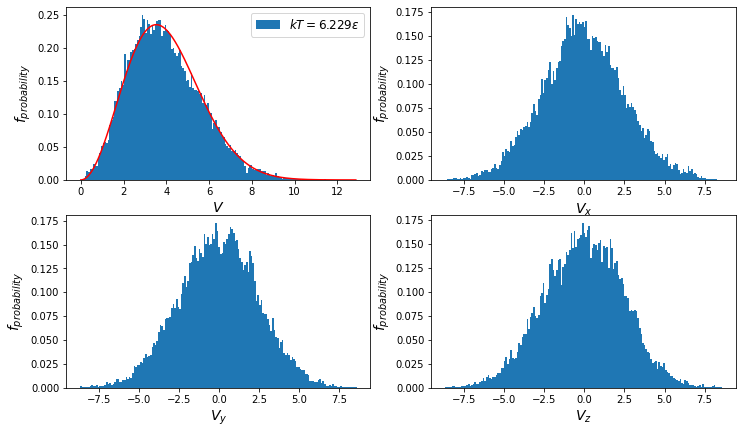

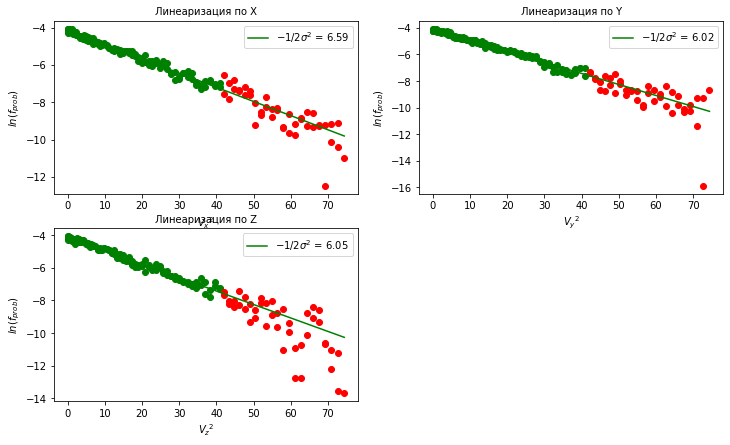

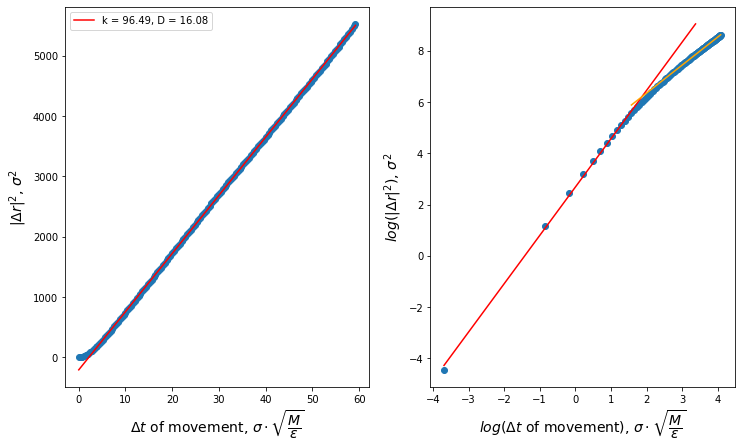

lambda = 12.113; D = 16.081; kT = 6.229 
 exp_section = 1.576; exp_d = 1.417; theor_section = 1.497; theor_d = 1.381 
--------------------


In [53]:
kT_def = plot_hists_from_file(path = '../graphs_rho_1_27/histograms_6_2.csv')
kT_gauss = plot_gauss_lines_from_file(path= '../graphs_rho_1_27/lines_6_2.csv', train_part=0.75)
# plot_energies_from_file(who_to_plot=['Total'], path='../graphs_rho_1_27/energies_6_2.csv')
D = plot_ready_diffusion(path='../graphs_rho_1_27/diffusion_ready/t_6_2_ready.csv')
calculate_sigma(kT=kT_def, D=D)

$T=4.7$:

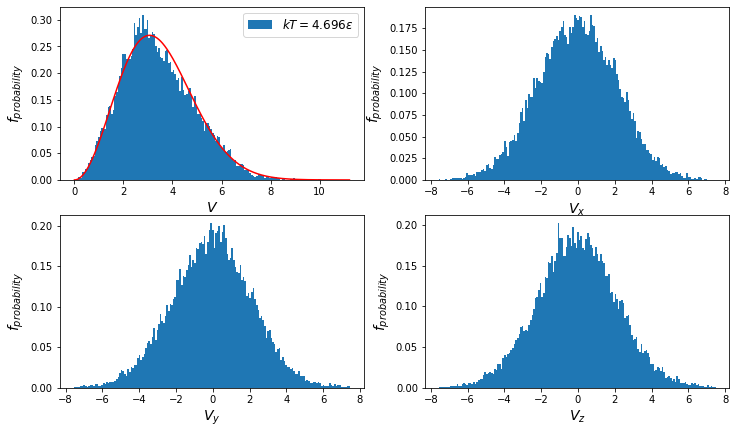

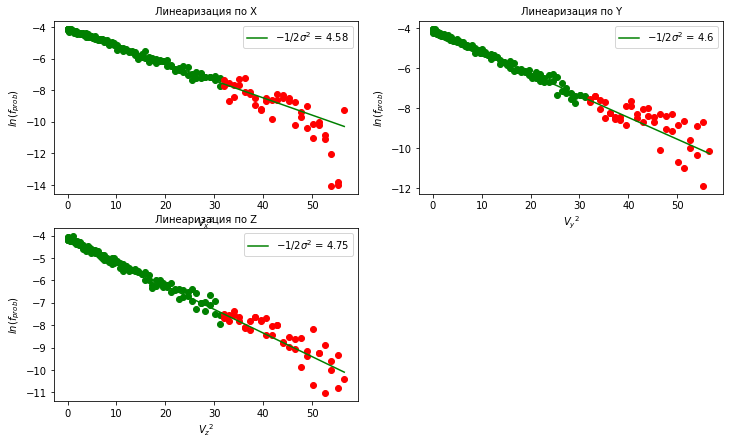

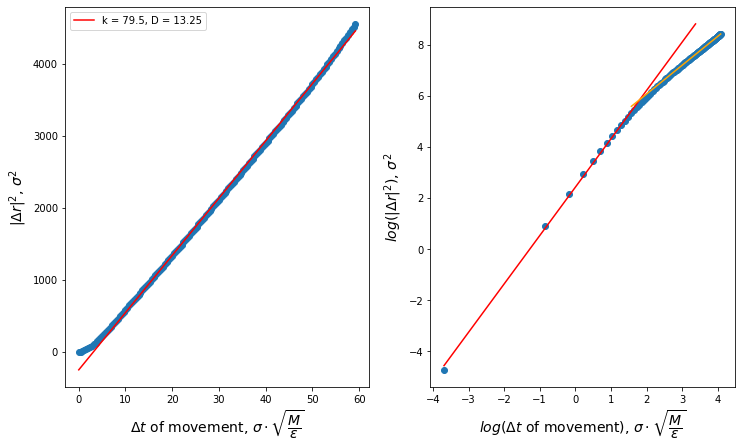

lambda = 11.495; D = 13.25; kT = 4.696 
 exp_section = 1.661; exp_d = 1.454; theor_section = 1.569; theor_d = 1.414 
--------------------


In [54]:
kT_def = plot_hists_from_file(path = '../graphs_rho_1_27/histograms_t_4_7.csv')
kT_gauss = plot_gauss_lines_from_file(path= '../graphs_rho_1_27/lines_t_4_7.csv', train_part=0.75)
# plot_energies_from_file(who_to_plot=['Total'], path='../graphs_rho_1_27/energies_t_4_7.csv')
D = plot_ready_diffusion(path='../graphs_rho_1_27/diffusion_ready/t_4_7_ready.csv')
calculate_sigma(kT=kT_def, D=D)

$T=4.0$:

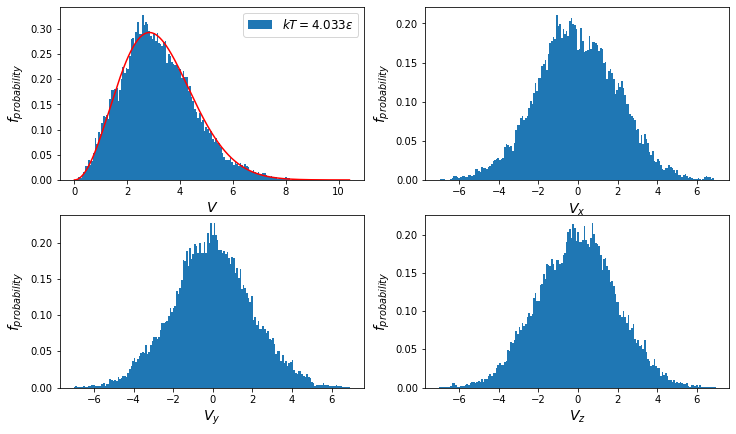

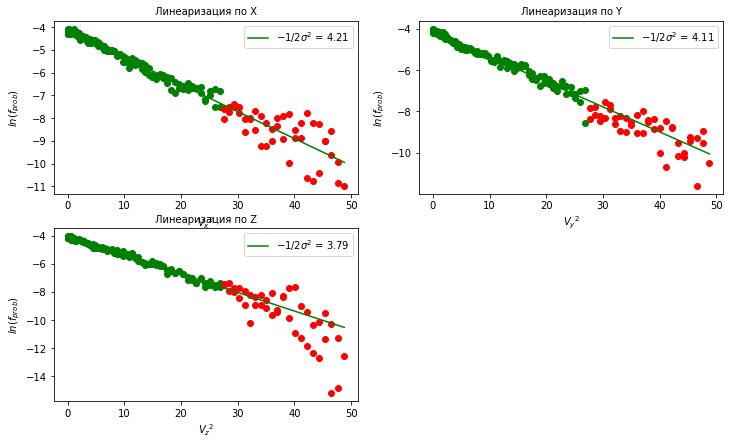

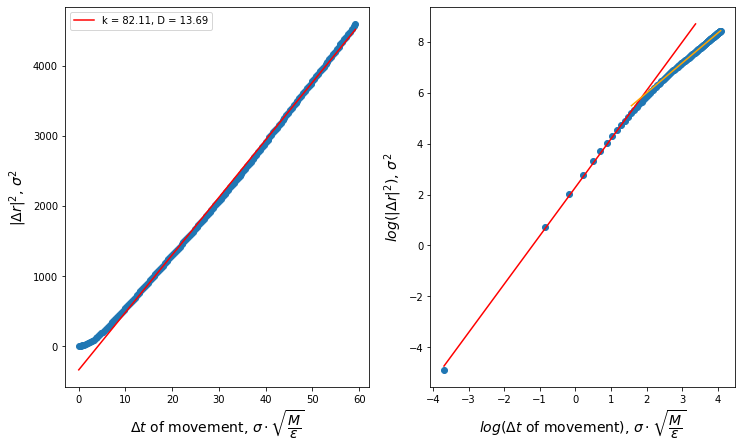

lambda = 12.811; D = 13.685; kT = 4.033 
 exp_section = 1.49; exp_d = 1.377; theor_section = 1.61; theor_d = 1.432 
--------------------


In [55]:
kT_def = plot_hists_from_file(path = '../graphs_rho_1_27/histograms_t_4.csv')
kT_gauss = plot_gauss_lines_from_file(path= '../graphs_rho_1_27/lines_t_4.csv', train_part=0.75)
# plot_energies_from_file(who_to_plot=['Total'], path='../graphs_rho_1_27/energies_4.csv')
D = plot_ready_diffusion(path='../graphs_rho_1_27/diffusion_ready/t_4_ready.csv')
calculate_sigma(kT=kT_def, D=D)

$T=3.2$:

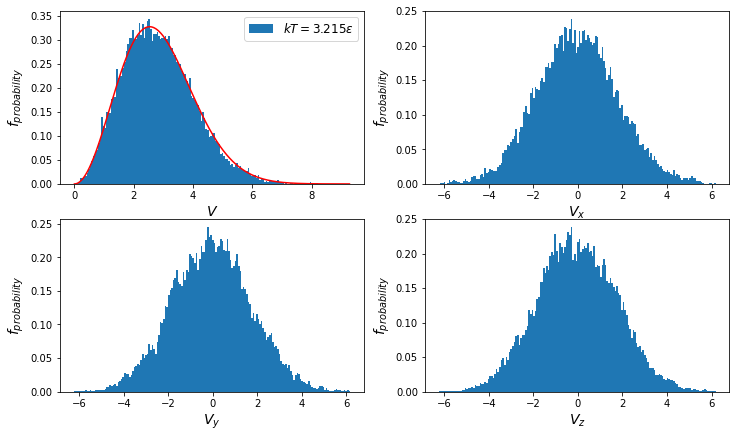

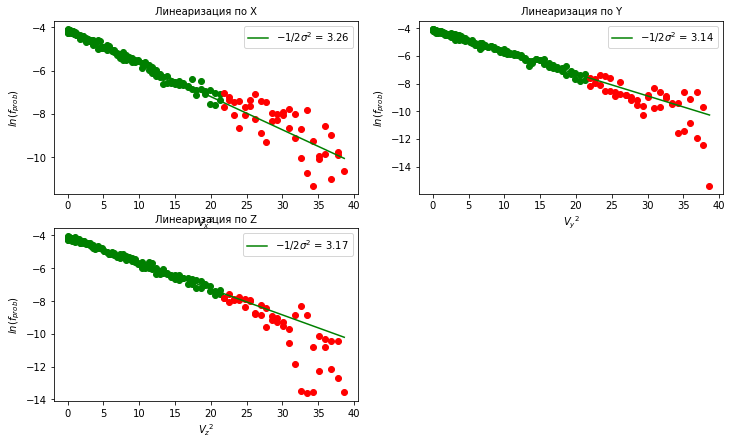

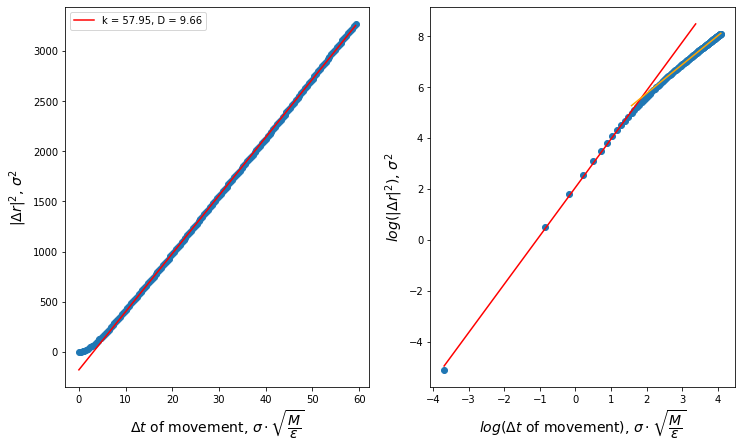

lambda = 10.126; D = 9.658; kT = 3.215 
 exp_section = 1.885; exp_d = 1.549; theor_section = 1.672; theor_d = 1.459 
--------------------


In [56]:
kT_def = plot_hists_from_file(path = '../graphs_rho_1_27/histograms3_2.csv')
kT_gauss = plot_gauss_lines_from_file(path= '../graphs_rho_1_27/lines3_2.csv', train_part=0.75)
# plot_energies_from_file(who_to_plot=['Total'], path='../graphs_rho_1_27/energies3_2.csv')
D = plot_ready_diffusion(path='../graphs_rho_1_27/diffusion_ready/t_3_2_ready.csv')
calculate_sigma(kT=kT_def, D=D)

$T=2.2$:

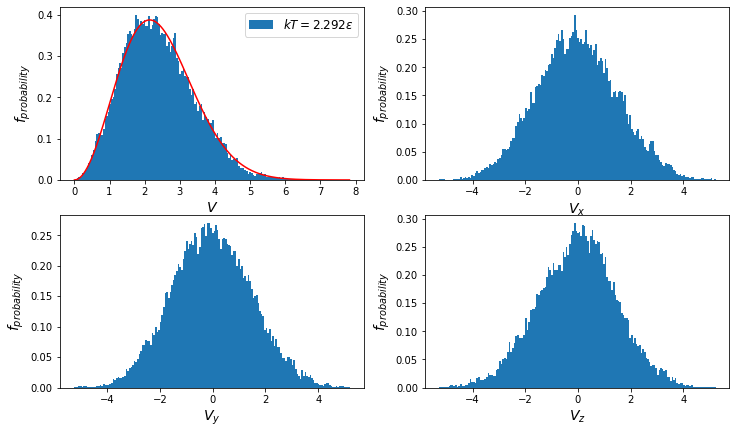

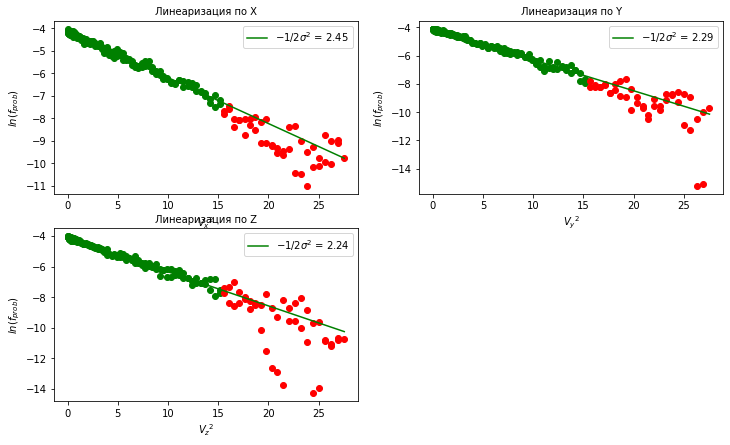

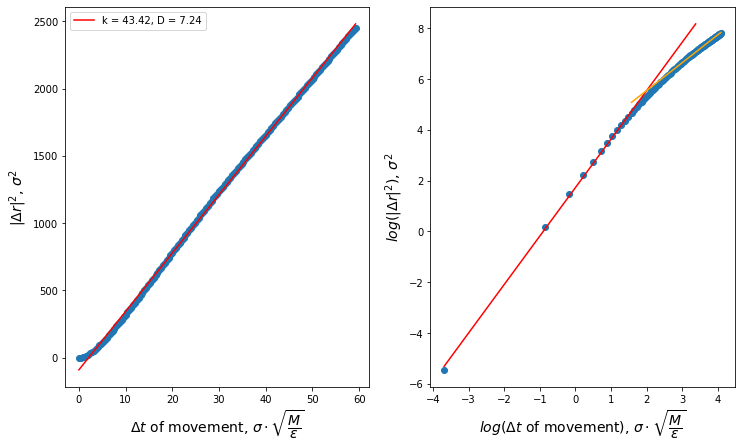

lambda = 8.987; D = 7.237; kT = 2.292 
 exp_section = 2.124; exp_d = 1.645; theor_section = 1.769; theor_d = 1.501 
--------------------


In [57]:
kT_def = plot_hists_from_file(path = '../graphs_rho_1_27/hists_2_3.csv')
kT_gauss = plot_gauss_lines_from_file(path= '../graphs_rho_1_27/lines_2_3.csv', train_part=0.75)
# plot_energies_from_file(who_to_plot=['Total'], path='../graphs_rho_1_27/energies_2_3.csv')
D = plot_ready_diffusion(path='../graphs_rho_1_27/diffusion_ready/t_2_3_ready.csv')
calculate_sigma(kT=kT_def, D=D)

$T=1.6$

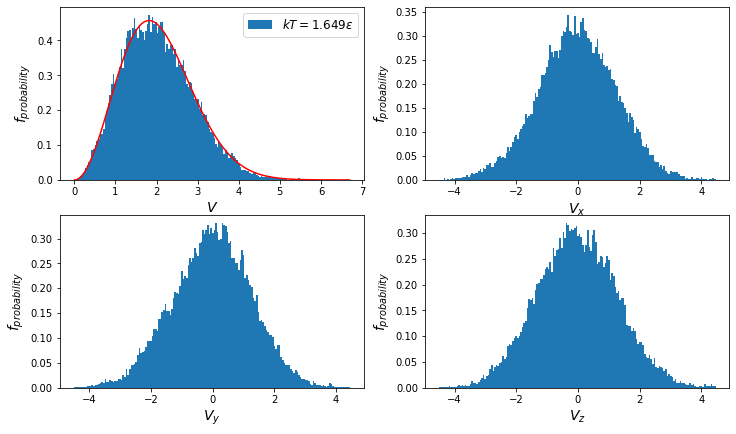

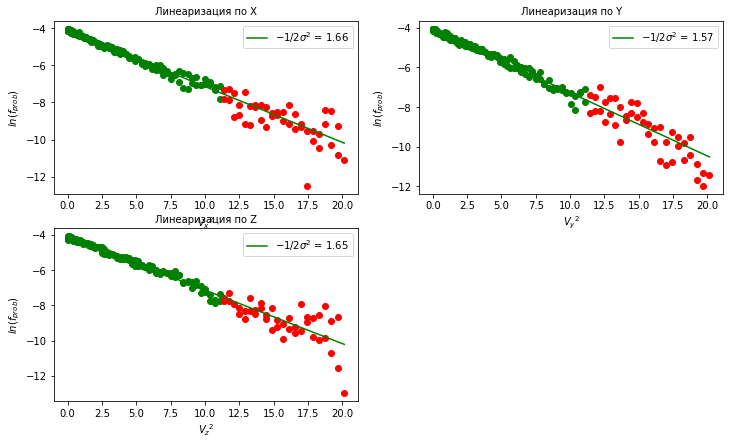

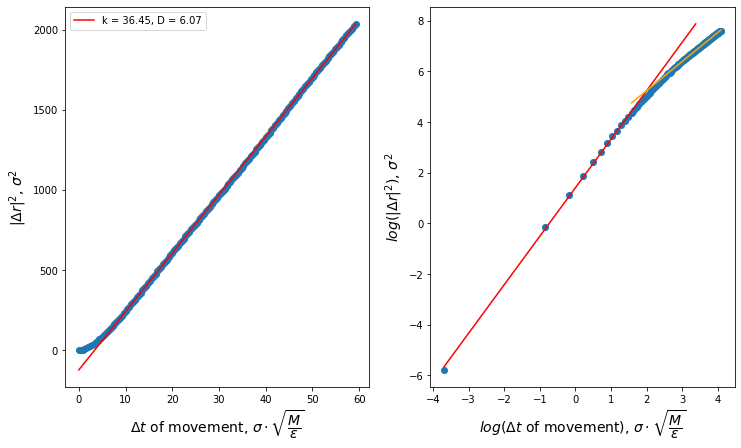

lambda = 8.894; D = 6.075; kT = 1.649 
 exp_section = 2.147; exp_d = 1.653; theor_section = 1.868; theor_d = 1.542 
--------------------


In [58]:
kT_def = plot_hists_from_file(path = '../graphs_rho_1_27/histograms_t_1_6.csv')
kT_gauss = plot_gauss_lines_from_file(path= '../graphs_rho_1_27/lines_t_1_6.csv', train_part=0.75)
# plot_energies_from_file(who_to_plot=['Total'], path='../graphs_rho_1_27/energies_t_1_6.csv')
D = plot_ready_diffusion(path='../graphs_rho_1_27/diffusion_ready/t_1_6_ready.csv')
calculate_sigma(kT=kT_def, D=D)

$T = 1.0$:

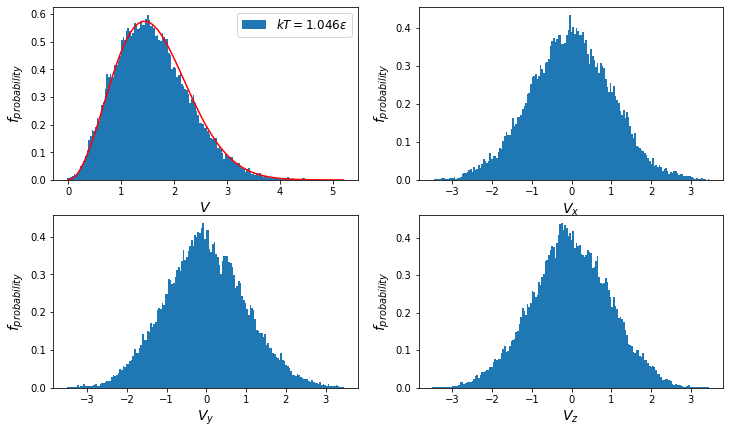

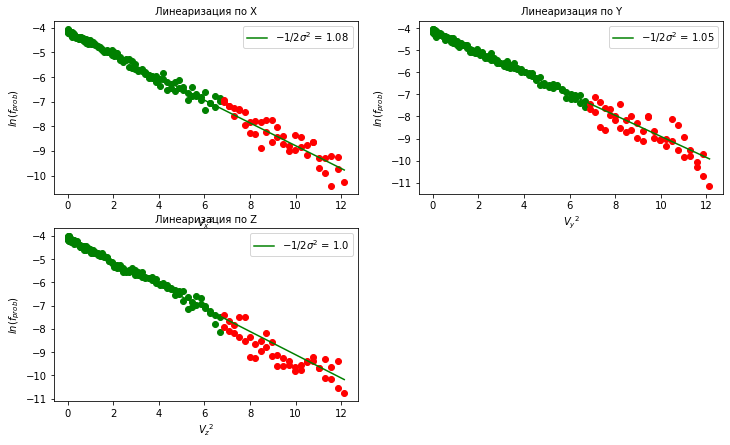

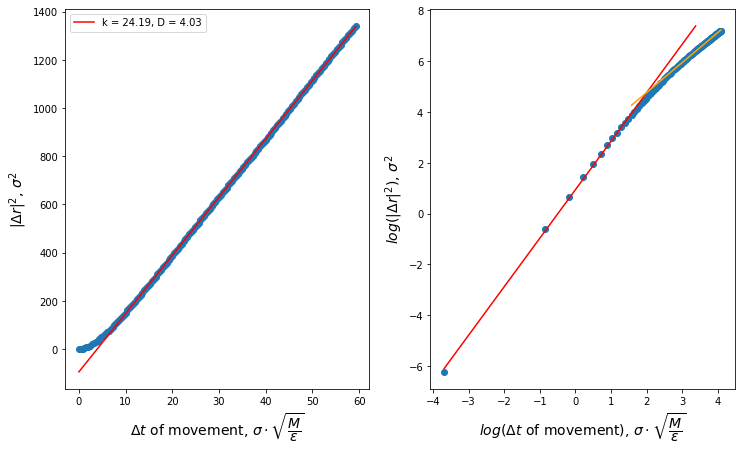

lambda = 7.41; D = 4.031; kT = 1.046 
 exp_section = 2.577; exp_d = 1.811; theor_section = 2.016; theor_d = 1.602 
--------------------


In [59]:
kT_def = plot_hists_from_file(path = '../graphs_rho_1_27/histograms_t_1.csv')
kT_gauss = plot_gauss_lines_from_file(path= '../graphs_rho_1_27/gauss_lines_t_1.csv', train_part=0.75)
# plot_energies_from_file(who_to_plot=['Total'], path='../graphs_rho_1_27/energies_t_1.csv')
D = plot_ready_diffusion(path='../graphs_rho_1_27/diffusion_ready/t_1_ready.csv')
calculate_sigma(kT=kT_def, D=D)

$T=0.68$:

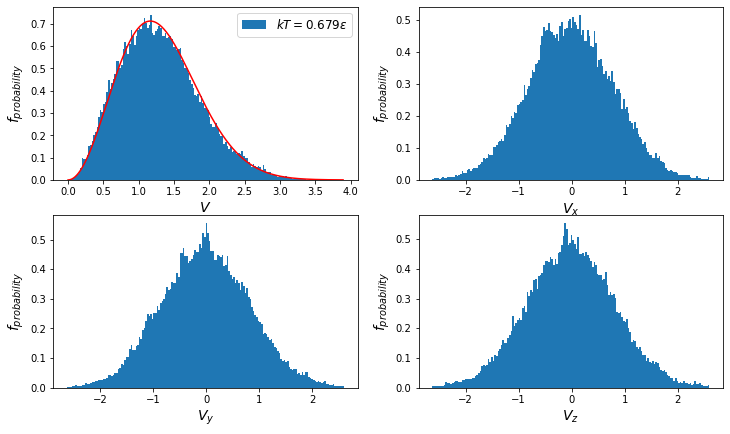

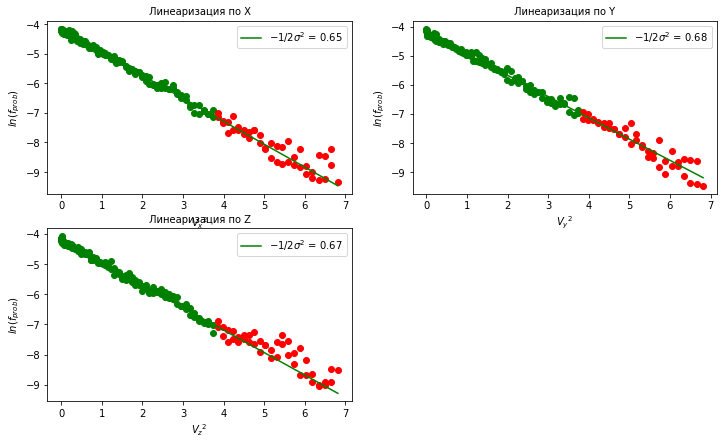

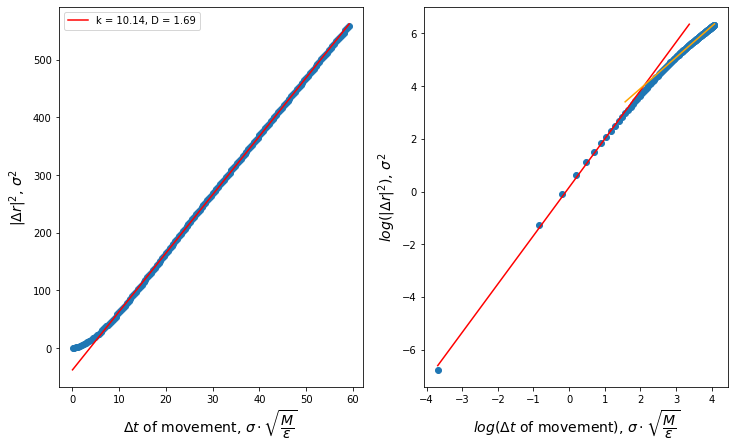

lambda = 3.853; D = 1.689; kT = 0.679 
 exp_section = 4.955; exp_d = 2.512; theor_section = 2.166; theor_d = 1.661 
--------------------


In [60]:
kT_def = plot_hists_from_file(path = '../graphs_rho_1_27/hists_0_68.csv')
kT_gauss = plot_gauss_lines_from_file(path= '../graphs_rho_1_27/lines_0_68.csv', train_part=0.75)
# plot_energies_from_file(who_to_plot=['Total'], path='../graphs_rho_1_27/energies_0_68.csv')
D = plot_ready_diffusion(path='../graphs_rho_1_27/diffusion_ready/t_0_68_ready.csv')
calculate_sigma(kT=kT_def, D=D)

---
## Плотность $\dfrac{1}{4}$:

$T=4.6$:

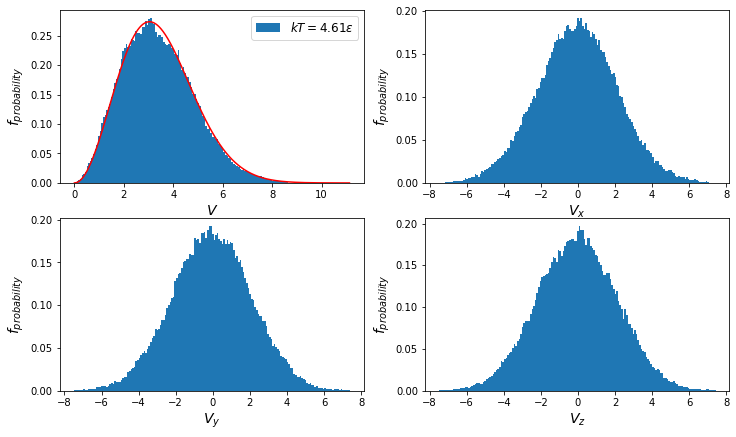

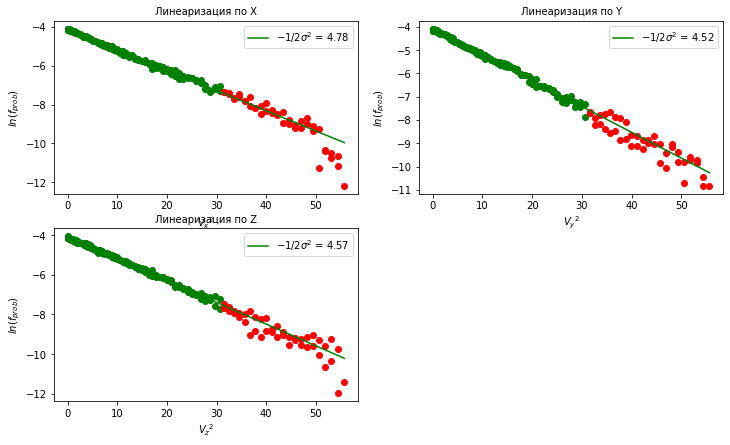

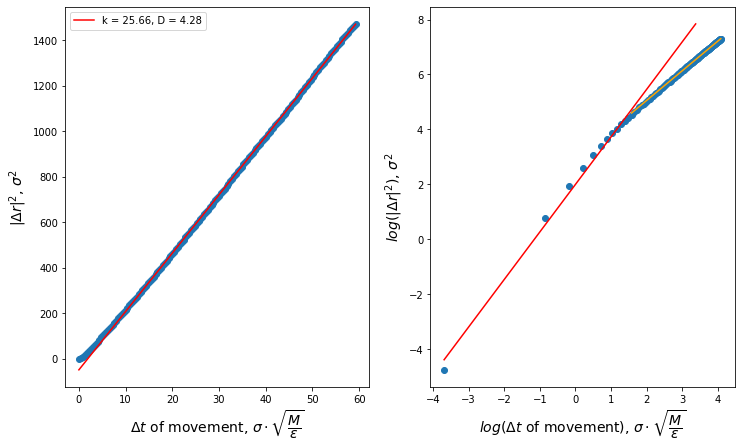

lambda = 3.745; D = 4.277; kT = 4.61 
 exp_section = 0.755; exp_d = 0.981; theor_section = 1.574; theor_d = 1.416 
--------------------


In [61]:
kT_def = plot_hists_from_file(path = '../graphs_rho_1_4/histograms_4_6.csv')
kT_gauss = plot_gauss_lines_from_file(path= '../graphs_rho_1_4/lines_4_6.csv', train_part=0.75)
# plot_energies_from_file(who_to_plot=['Total'], path='../graphs_rho_1_4/energies_4_6.csv')
D = plot_ready_diffusion(path='../graphs_rho_1_4/diffusion_ready/t_4_6_ready.csv')
calculate_sigma(kT=kT_def, D=D, rho=0.25)

$T = 2.7$:

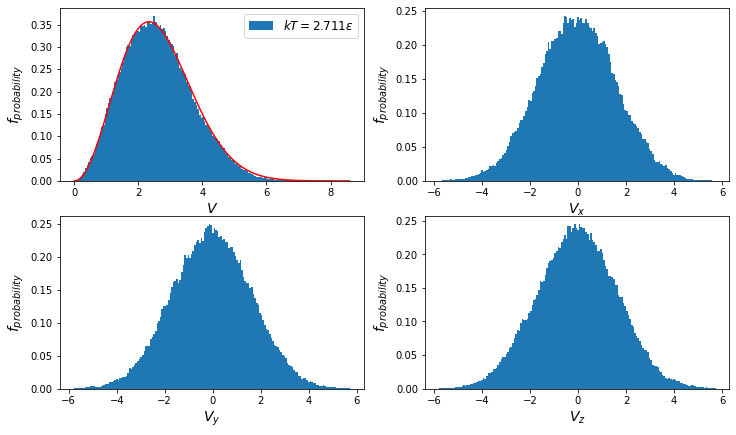

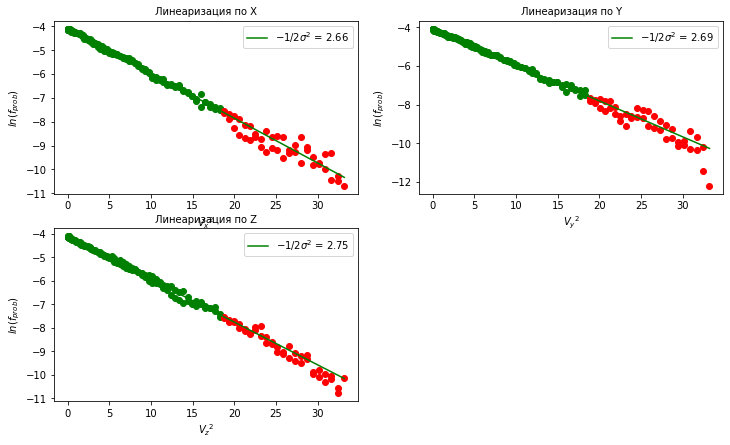

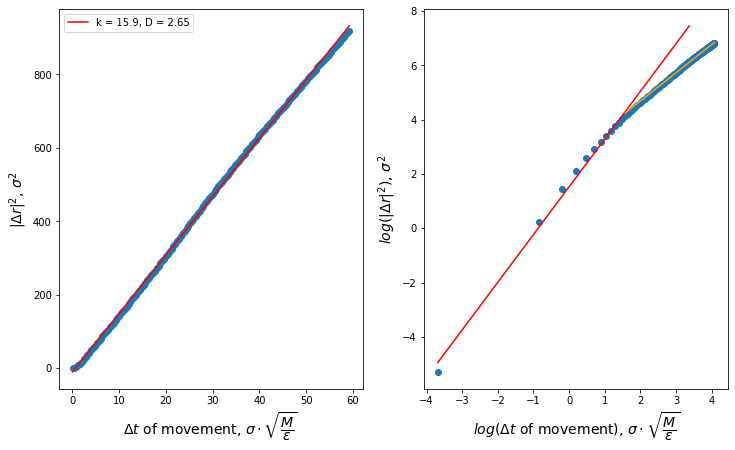

lambda = 3.026; D = 2.65; kT = 2.711 
 exp_section = 0.935; exp_d = 1.091; theor_section = 1.72; theor_d = 1.48 
--------------------


In [62]:
kT_def = plot_hists_from_file(path = '../graphs_rho_1_4/histograms_2_7.csv')
kT_gauss = plot_gauss_lines_from_file(path= '../graphs_rho_1_4/lines_2_7.csv', train_part=0.75)
# plot_energies_from_file(who_to_plot=['Total'], path='../graphs_rho_1_4/energies_2_7.csv')
D = plot_ready_diffusion(path='../graphs_rho_1_4/diffusion_ready/t_2_7_ready.csv')
calculate_sigma(kT=kT_def, D=D, rho=0.25)

$T=1.5$;

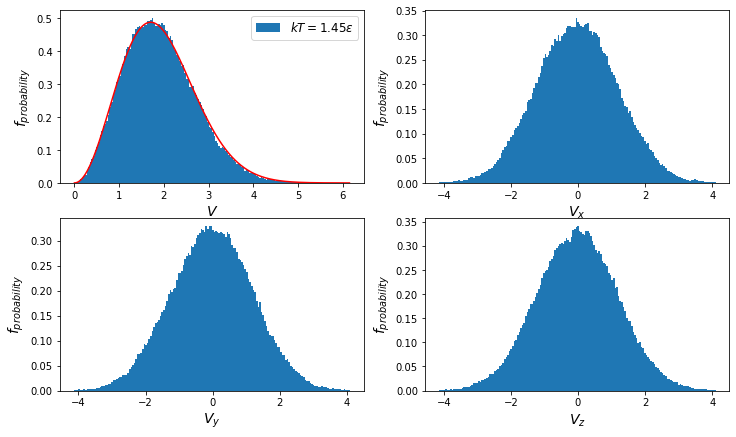

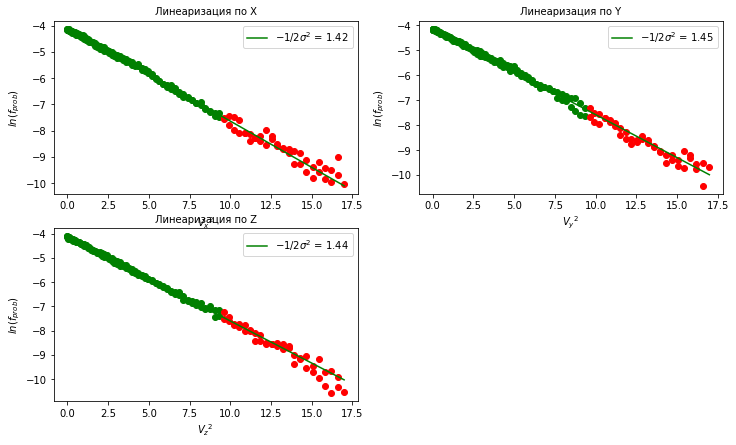

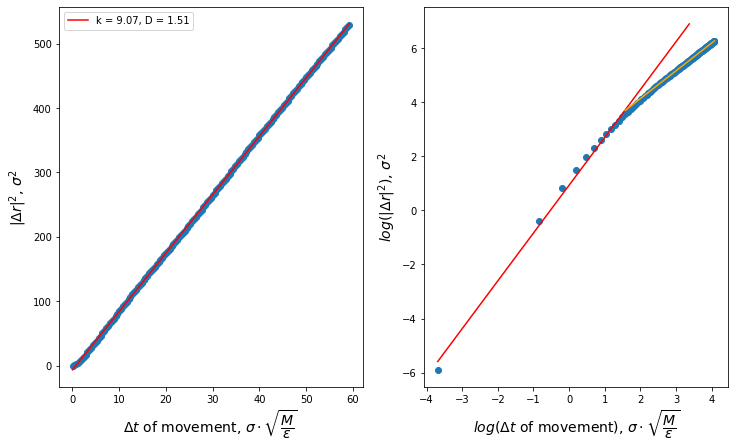

lambda = 2.361; D = 1.512; kT = 1.45 
 exp_section = 1.198; exp_d = 1.235; theor_section = 1.909; theor_d = 1.559 
--------------------


In [63]:
kT_def = plot_hists_from_file(path = '../graphs_rho_1_4/histograms_1_5.csv')
kT_gauss = plot_gauss_lines_from_file(path= '../graphs_rho_1_4/lines_1_5.csv', train_part=0.75)
# plot_energies_from_file(who_to_plot=['Total'], path='../graphs_rho_1_4/energies_1_5.csv')
D = plot_ready_diffusion(path='../graphs_rho_1_4/diffusion_ready/t_1_5_ready.csv')
calculate_sigma(kT=kT_def, D=D, rho=0.25)

---
## Построение зависимости коэффициента диффузии от температуры:

In [64]:
rhos = ["1 / 27", "1 / 4"]

D_files = [
    '../graphs_rho_1_27/_dif_from_t_rho_1_27.csv',
    '../graphs_rho_1_4/_dif_from_t_rho_1_4.csv'
]

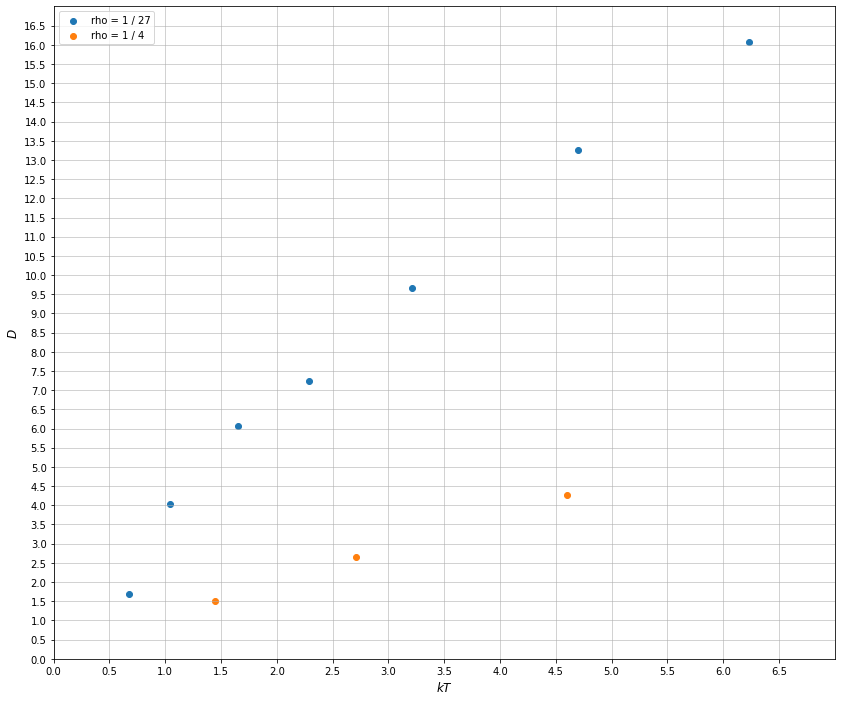

In [65]:
plt.figure(figsize=(14, 12))
for (i, file) in enumerate(D_files):
    df = pd.read_csv(file)
    plt.scatter(df.kT, df.D, label=f'rho = {rhos[i]}')

plt.grid(alpha=0.7)
plt.ylim(ymin=0, ymax=17)
plt.xlim(xmin=0, xmax=7)
plt.xticks(np.arange(0, 7, 0.5))
plt.yticks(np.arange(0, 17, 0.5))
plt.legend(loc='best')
plt.xlabel(r'$kT$', fontsize=12)
plt.ylabel(r'$D$', fontsize=12)
plt.show()

**В логарифмических координатах:**

rho = 1 / 27; (k, b) = (0.9409778078630561, 1.1608911363487553)
rho = 1 / 4; (k, b) = (0.900551669427576, 0.07806800370848921)


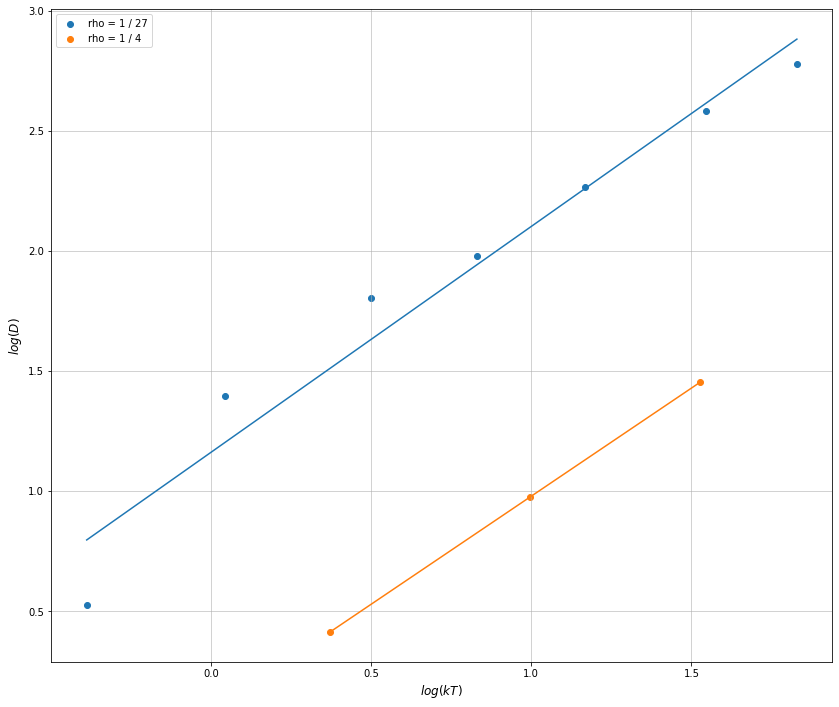

In [66]:
plt.figure(figsize=(14, 12))
for (i, file) in enumerate(D_files):
    df = pd.read_csv(file)
    k, _, b, _ = calculate_k(np.log(df.kT), np.log(df.D))
    print(f'rho = {rhos[i]}; (k, b) = {k, b}')
    x = np.linspace(min(np.log(df.kT)), max(np.log(df.kT)), 50)
    plt.scatter(np.log(df.kT), np.log(df.D), label=f'rho = {rhos[i]}')
    plt.plot(x, k * x + b)

plt.grid(alpha=0.7)
plt.legend(loc='best')
plt.xlabel(r'$log(kT)$', fontsize=12)
plt.ylabel(r'$log(D)$', fontsize=12)
plt.show()

Не $\sqrt{T}$, потому что мы считаем, что $\sigma=\sigma(T)$

---
### **Про диаметр молекул:**

$\rho = \dfrac{1}{27}$:

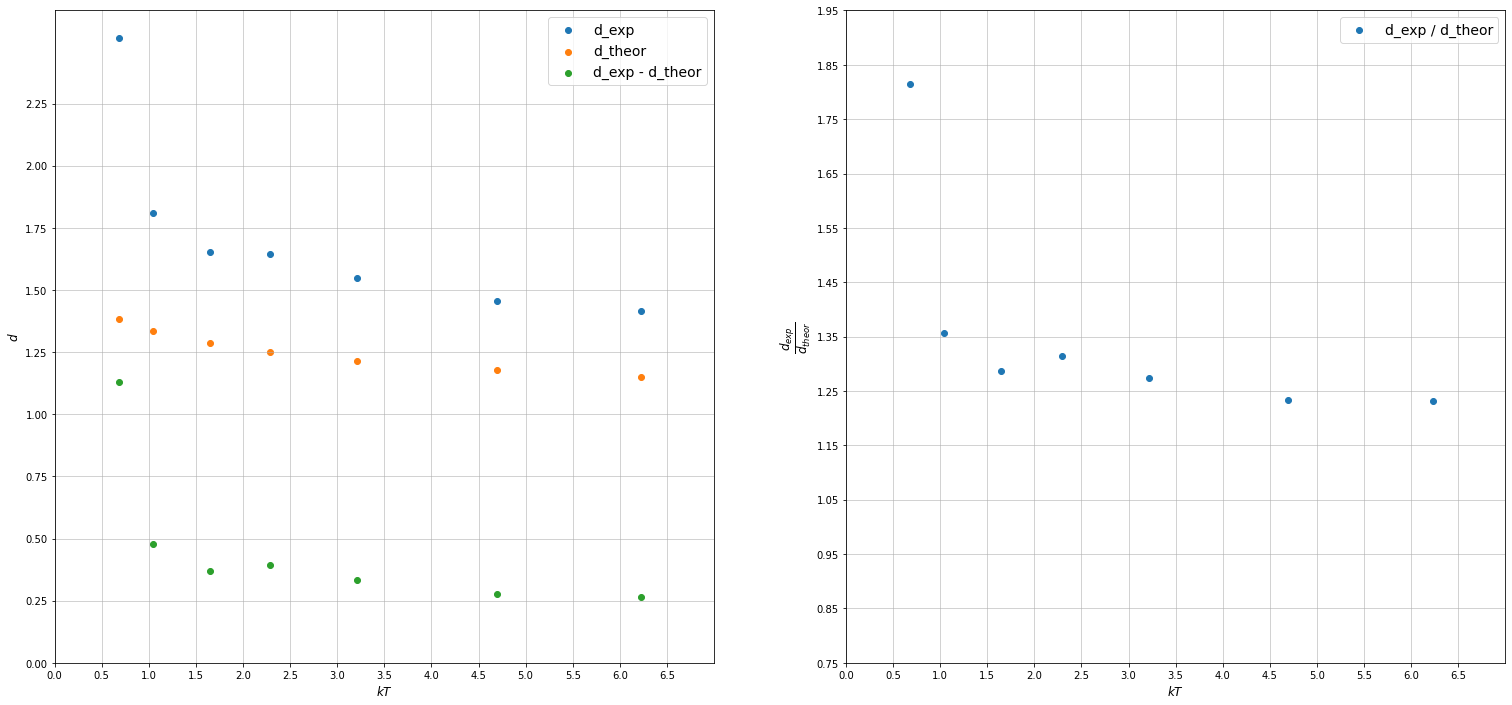

In [67]:
plt.figure(figsize=(26, 12))

plt.subplot(1, 2, 1)
for (i, file) in enumerate(D_files[:-1]):   # пока для плотности 0.25 не занес диаметры
    df = pd.read_csv(file)
    plt.scatter(df.kT, df['d_exp'], label=f'd_exp')
    plt.scatter(df.kT, df['d_theor'], label=f'd_theor')
    plt.scatter(df.kT, df.d_exp - df.d_theor, label=f'd_exp - d_theor')

plt.grid(alpha=0.7)
plt.legend(loc='best', fontsize=14)
plt.yticks(np.arange(0, 2.5, 0.25))
plt.xlim(xmin=0, xmax=7)
plt.xticks(np.arange(0, 7, 0.5))
plt.xlabel(r'$kT$', fontsize=12)
plt.ylabel(r'$d$', fontsize=12)

plt.subplot(1, 2, 2)
for (i, file) in enumerate(D_files[:-1]):   # пока для плотности 0.25 не занес диаметры
    df = pd.read_csv(file)
    plt.scatter(df.kT, df['d_exp'] / df['d_theor'], label=f'd_exp / d_theor')

plt.grid(alpha=0.7)
plt.legend(loc='best', fontsize=14)
plt.xlim(xmin=0, xmax=7)
plt.xticks(np.arange(0, 7, 0.5))
plt.yticks(np.arange(0.75, 2, 0.1))
plt.xlabel(r'$kT$', fontsize=12)
plt.ylabel(r'$\dfrac{d_{exp}}{d_{theor}}$', fontsize=12)

plt.show()

$\rho = \dfrac{1}{4}$:

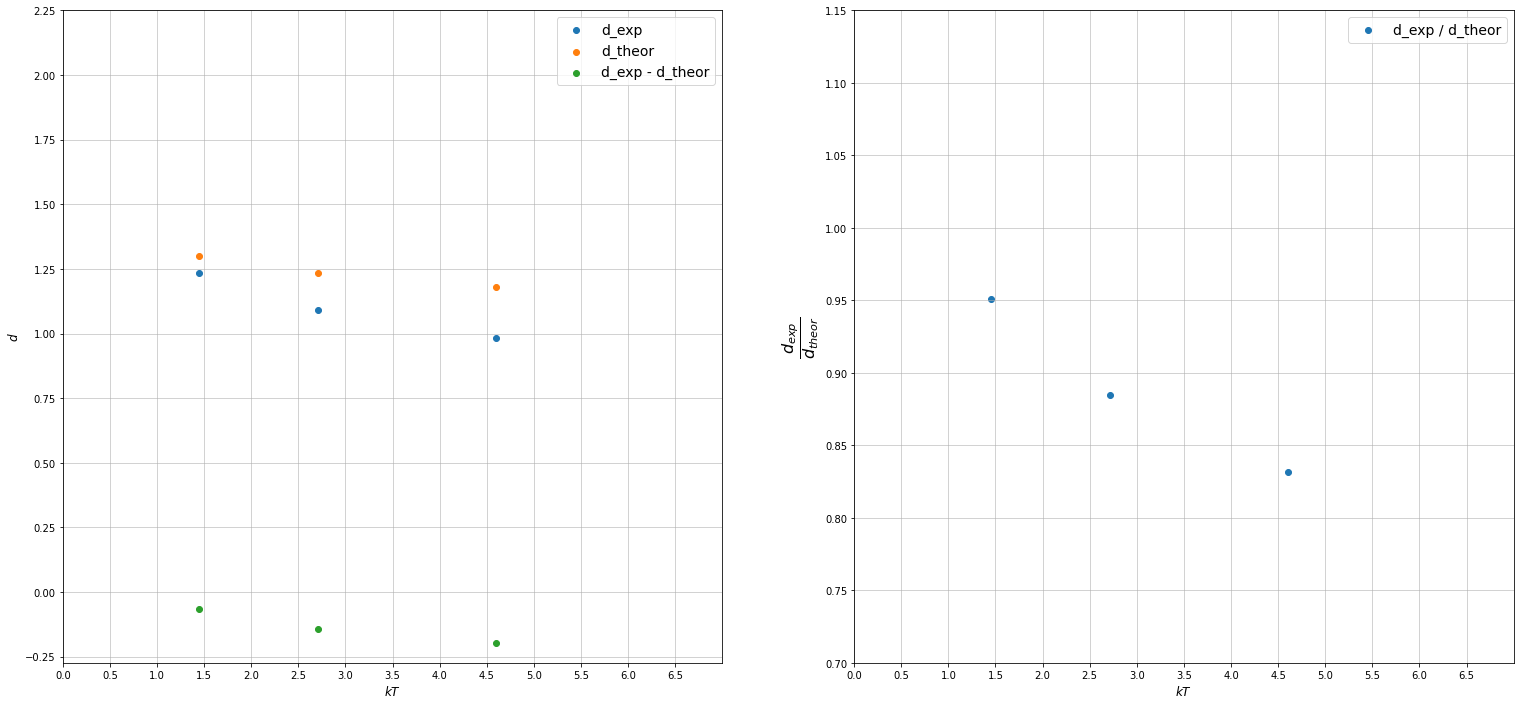

In [68]:
plt.figure(figsize=(26, 12))

plt.subplot(1, 2, 1)
for (i, file) in enumerate(D_files[1:]):   # пока для плотности 0.25 не занес диаметры
    df = pd.read_csv(file)
    plt.scatter(df.kT, df['d_exp'], label=f'd_exp')
    plt.scatter(df.kT, df['d_theor'], label=f'd_theor')
    plt.scatter(df.kT, df.d_exp - df.d_theor, label=f'd_exp - d_theor')

plt.grid(alpha=0.7)
plt.legend(loc='best', fontsize=14)
plt.yticks(np.arange(-0.25, 2.5, 0.25))
plt.xlim(xmin=0, xmax=7)
plt.xticks(np.arange(0, 7, 0.5))
plt.xlabel(r'$kT$', fontsize=12)
plt.ylabel(r'$d$', fontsize=12)

plt.subplot(1, 2, 2)
for (i, file) in enumerate(D_files[1:]):   # пока для плотности 0.25 не занес диаметры
    df = pd.read_csv(file)
    plt.scatter(df.kT, df['d_exp'] / df['d_theor'], label=f'd_exp / d_theor')

plt.grid(alpha=0.7)
plt.legend(loc='best', fontsize=14)
plt.xlim(xmin=0, xmax=7)
plt.xticks(np.arange(0, 7, 0.5))
plt.yticks(np.arange(0.7, 1.2, 0.05))
plt.xlabel(r'$kT$', fontsize=12)
plt.ylabel(r'$\dfrac{d_{exp}}{d_{theor}}$', fontsize=16)

plt.show()

Эффективный диаметр = 1 будет только при бесконечной температуре, если ориентироваться на формулу Сазерленда или на предложенную мной с -1/12 в степени, нас вполне устраивает, что функция стремится к 1 при увеличении температуры

---
### Зависимость длины свободного пробега от температуры